# Figure 2 : B16-CTL-MDSC Model Construction

In [1]:
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from matplotlib.ticker import ScalarFormatter

In [2]:
%run 00_data_preprocessing.ipynb

In [3]:
dir_path = '../../results/main/02'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

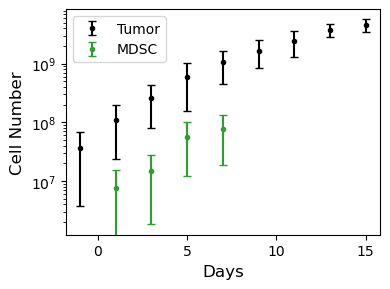

In [4]:
plt.figure(figsize=(4, 3))
plt.errorbar(unt_v_days, unt_v_data, yerr=unt_v_std, fmt='o', capsize=3, markersize=3, color='black', label='Tumor')
plt.errorbar(unt_mdsc['day'], unt_mdsc['N_mean'], yerr=unt_mdsc['N_std'], fmt='o', capsize=3, markersize=3, color='tab:green',label='MDSC')
plt.xlabel('Days', fontsize=12)
plt.ylabel('Cell Number', fontsize=12)
#plt.title('Untreated')
plt.yscale('log')
plt.legend()
plt.tight_layout()

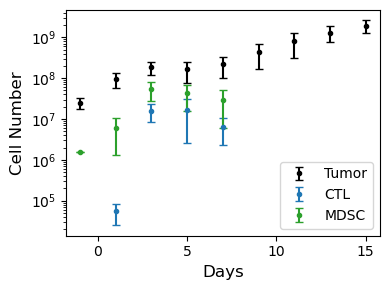

In [5]:
plt.figure(figsize=(4, 3))
plt.errorbar(v_days, v_data, yerr=v_std, fmt='o', capsize=3, markersize=3, color='black', label='Tumor')
plt.errorbar(ctl_days, ctl_data, yerr=ctl_std, fmt='o', capsize=3, markersize=3, color='tab:blue',label='CTL')
plt.errorbar(mdsc_days, mdsc_data, yerr=mdsc_std, fmt='o', capsize=3, markersize=3, color='tab:green',label='MDSC')
plt.xlabel('Days', fontsize=12)
plt.ylabel('Cell Number', fontsize=12)
#plt.title('CTL therapy')
plt.yscale('log')
plt.legend()
plt.tight_layout()

# Model construction

## Model1
\begin{align*}
\frac{dV}{dt} &= v_r V \log\left(\frac{v_k}{V}\right) - k_s S V \\
\frac{dE}{dt} &= F(t) + \frac{e_p E V^2}{V^2 + k_v} - d_m M E - d_e E \\
\frac{dD}{dt} &= d_m M E + d_e E - d_d D \\
\frac{dS}{dt} &= E - d_s S \\
\frac{dM}{dt} &= m_f F(t) + m_v V - m_d M
\end{align*}


## Model2
\begin{align*}
\frac{dV}{dt} &= v_r V \log\left(\frac{v_k}{V}\right) - k_s S V \\
\frac{dE}{dt} &= F(t) + \frac{e_p E V^2}{V^2 + k_v} - \frac{d_m M E}{k_m + M} - d_e E \\
\frac{dD}{dt} &= \frac{d_m M E}{k_m + M} + d_e E - d_d D \\
\frac{dS}{dt} &= E - d_s S \\
\frac{dM}{dt} &= m_f F(t) + m_v V - m_d M
\end{align*}

## Model Construction

In [6]:
t_start = 2  # Delay (in days) before CTLs infiltrate the tumor after injection

def ctl_pulse(t, dose_list, dose_days, delta_t):
    """Return the CTL input function F(t), based on dose schedule and delivery window."""
    total = 0
    for dose, day in zip(dose_list, dose_days):
        if day + t_start <= t < day + t_start + delta_t:
            total += dose / delta_t
    return total

In [7]:
## Model1: Lunear Suppression by MDSCs
def model1(y, t, dose_list, dose_days, delta_t, params):
    k_s, e_p, d_e, d_d, d_s, d_m, m_f = params
    V, E, D, S, M = y
    F_t = ctl_pulse(t, dose_list, dose_days, delta_t)

    # ===ODE Model===
    #dVdt = v_r * V * np.log(v_k / V) - k_s * S * V
    if V <= 0:
        dVdt = 0  
    else:
        dVdt = v_r * V * np.log(v_k / V) - k_s * S * V

    dEdt = F_t + e_p * E * V**2 / (V**2 + k_v) - d_m * M * E - d_e * E
    dDdt = d_m * M * E + d_e * E - d_d * D
    dSdt = E - d_s * S
    dMdt = m_f * F_t + m_v * V - m_d * M

    return [dVdt, dEdt, dDdt, dSdt, dMdt]

In [8]:
# Model2: Saturable Suppression by MDSCs
def model2(y, t, dose_list, dose_days, delta_t, params):
    k_s, e_p, d_e, d_d, d_s, d_m, m_f, k_m = params
    V, E, D, S, M = y
    F_t = ctl_pulse(t, dose_list, dose_days, delta_t)

    # ===ODE Model===
    # dVdt = v_r * V * np.log(v_k / V) - k_s * S * V
    if V <= 0:
        dVdt = 0  
    else:
        dVdt = v_r * V * np.log(v_k / V) - k_s * S * V
    dEdt = F_t + e_p * E * V**2 / (V**2 + k_v)  - d_m * E * M /(k_m+M) - d_e * E
    dDdt = d_m * E * M /(k_m+M) + d_e * E - d_d * D
    dSdt = E - d_s * S
    dMdt = m_f * F_t + m_v * V - m_d * M

    return [dVdt, dEdt, dDdt, dSdt, dMdt]

## visualization function

In [9]:
def set_scientific_yticks(ax):
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Plot with ACT fitting data
def vis_act_fit(sol, out_dir=None, figure_name=None):
    V_sol, E_sol, D_sol, S_sol, M_sol = sol.T
    T_sol = E_sol + D_sol

    # === Plot ===
    plt.figure(figsize=(16, 4), dpi=200)
    plt.rcParams["font.size"] = 12

    # --- Panel A: Tumor volume ---
    ax1 = plt.subplot(1, 4, 1)
    ax1.plot(t_eval, V_sol, label='Model', color='blue', linewidth=2)
    ax1.errorbar(v_days, v_data, yerr=v_std, fmt='o', color='black',
                 capsize=3, markersize=3, label='Data')
    ax1.set_xlabel("Days")
    ax1.set_ylabel("B16 (cells)")
    ax1.set_title("B16 Dynamics")
    ax1.legend()
    set_scientific_yticks(ax1)

    # --- Panel B: MDSC ---
    ax2 = plt.subplot(1, 4, 2)
    ax2.plot(t_eval, M_sol, label='Model', color='blue')
    ax2.errorbar(mdsc_days, mdsc_data, yerr=mdsc_std, fmt='o', color='black',
                 capsize=3, markersize=3, label='Data')
    ax2.set_xlabel("Days")
    ax2.set_ylabel("MDSC (cells)")
    ax2.set_title("MDSC Dynamics")
    ax2.legend()
    set_scientific_yticks(ax2)

    # --- Panel C: CTL ---
    ax3 = plt.subplot(1, 4, 3)
    ax3.plot(t_eval, T_sol, label='Total (E+D)', color='blue', linewidth=2)
    ax3.plot(t_eval, E_sol, label='Effector (E)', color='skyblue', linewidth=2)
    ax3.plot(t_eval, D_sol, label='Exhausted (D)', color='gray', linewidth=2)
    ax3.errorbar(ctl_days, ctl_data, yerr=ctl_std, fmt='o', color='black',
                 capsize=3, markersize=3, label='Data')
    ax3.set_xlabel('Days')
    ax3.set_ylabel('TST (cells)')
    ax3.set_title('TST Dynamics')
    ax3.legend()
    set_scientific_yticks(ax3)

    # --- Panel D: Suppression Effect ---
    ax4 = plt.subplot(1, 4, 4)
    ax4.plot(t_eval, S_sol, label='Model', color='blue', linewidth=2)
    ax4.set_xlabel('Days')
    ax4.set_ylabel('Tumor Suppression')
    ax4.set_title('Tumor Suppression')
    ax4.legend()
    set_scientific_yticks(ax4)

    plt.tight_layout()

    # === Save if out_dir is provided ===
    if out_dir is not None and figure_name is not None:
        os.makedirs(out_dir, exist_ok=True)
        pdf_path = os.path.join(out_dir, f"{figure_name}.pdf")
        jpeg_path = os.path.join(out_dir, f"{figure_name}.jpeg")
        plt.savefig(pdf_path, dpi=300)
        plt.savefig(jpeg_path, dpi=300)
        print(f"Figure saved: {pdf_path}, {jpeg_path}")

    plt.show()

In [10]:
def vis_act(sol, out_dir=None, figure_name=None):
    V_sol, E_sol, D_sol, S_sol, M_sol = sol.T
    T_sol = E_sol + D_sol

    # === Plot ===
    plt.figure(figsize=(16, 4), dpi=200)
    plt.rcParams["font.size"] = 12

    # --- Panel A: Tumor volume ---
    ax1 = plt.subplot(1, 4, 1)
    ax1.plot(t_eval, V_sol, label='Model', color='blue', linewidth=2)
    ax1.set_xlabel("Days")
    ax1.set_ylabel("B16 (cells)")
    ax1.set_title("B16 Dynamics")
    ax1.legend()
    set_scientific_yticks(ax1)

    # --- Panel B: MDSC ---
    ax2 = plt.subplot(1, 4, 2)
    ax2.plot(t_eval, M_sol, label='Model', color='blue')
    ax2.set_xlabel("Days")
    ax2.set_ylabel("MDSC (cells)")
    ax2.set_title("MDSC Dynamics")
    ax2.legend()
    set_scientific_yticks(ax2)

    # --- Panel C: CTL ---
    ax3 = plt.subplot(1, 4, 3)
    ax3.plot(t_eval, T_sol, label='Total (E+D)', color='blue', linewidth=2)
    ax3.plot(t_eval, E_sol, label='Effector (E)', color='skyblue', linewidth=2)
    ax3.plot(t_eval, D_sol, label='Exhausted (D)', color='gray', linewidth=2)
    ax3.set_xlabel('Days')
    ax3.set_ylabel('TST (cells)')
    ax3.set_title('TST Dynamics')
    ax3.legend()
    set_scientific_yticks(ax3)

    # --- Panel D: Suppression Effect ---
    ax4 = plt.subplot(1, 4, 4)
    ax4.plot(t_eval, S_sol, label='Model', color='blue', linewidth=2)
    ax4.set_xlabel('Days')
    ax4.set_ylabel('Tumor Suppression')
    ax4.set_title('Tumor Suppression')
    ax4.legend()
    set_scientific_yticks(ax4)

    plt.tight_layout()

    # === Save if out_dir is provided ===
    if out_dir is not None and figure_name is not None:
        os.makedirs(out_dir, exist_ok=True)
        pdf_path = os.path.join(out_dir, f"{figure_name}.pdf")
        jpeg_path = os.path.join(out_dir, f"{figure_name}.jpeg")
        plt.savefig(pdf_path, dpi=300)
        plt.savefig(jpeg_path, dpi=300)
        print(f"Figure saved: {pdf_path}, {jpeg_path}")

    plt.show()

# Parameter Optimization

## optimization function

In [11]:
# ==Fixed param ==
# v_r = 8.52e-2
# v_k = 3.16e+10
# m_v = 5.87e-2
# m_d = 3.27e-1

v_r = 9.99e-2
v_k = 1.64e+10
m_v = 4.87e-2
m_d = 3.06e-1

# Other article param
k_v = 2.02e7

In [12]:
# Compute weighted squared error for fixed single-dose CTL schedule.
def loss_function(params, ode_system):
    # Fixed CTL injection schedule
    dose_list = [1e7]
    dose_days = [0]
    delta_t = 1

    # initial conditions
    y0 = [v_data[0], 0, 0, 0, mdsc_data[0]] # y = [V, E, D, S, M]
    t = np.arange(-1, 17.01, 0.01)

    # solve ODE system
    sol = odeint(ode_system, y0, t, 
                 args=(dose_list, dose_days, delta_t, params),
                 hmax=0.01)
    
    V_sol, E_sol, D_sol, S_sol, M_sol = sol.T
    E_total_sol= E_sol + D_sol

    # Indices matching data points
    v_idx = [np.abs(t - day).argmin() for day in v_days]
    ctl_idx = [np.abs(t - day).argmin() for day in ctl_days]
    mdsc_idx = [np.abs(t - day).argmin() for day in mdsc_days[1:]]

    # Weighted squared errors
    error_v = np.sum(((V_sol[v_idx] - v_data) / v_std) ** 2)
    error_ctl = np.sum(((E_total_sol[ctl_idx] - ctl_data) / ctl_std) ** 2)
    error_mdsc = np.sum(((M_sol[mdsc_idx] - mdsc_data[1:]) / mdsc_std[1:]) ** 2)

    return error_v + error_ctl + error_mdsc

## Optimize

In [13]:
loss_function([1.4e-7, 1.3, 0.9, 0.46, 0.86, 0.8, 3.5, 5e5], model2)

16.756856367831336

In [77]:
model_configs = {
    'Model1': {
        'ode': model1,
        'param_bounds': [
            (1e-8, 2e-7),  # k_s
            (0.5, 2),      # e_p
            (0.5, 2),      # d_e
            (0.1, 1),      # d_d
            (0.5, 5),      # d_s
            (1e-9, 5e-8),  # d_m
            (2, 5),        # m_f
        ],
        'param_names': ['k_s', 'e_p', 'd_e', 'd_d', 'd_s', 'd_m', 'm_f']
    },
    'Model2': {
        'ode': model2,
        'param_bounds': [
            (1e-8, 2e-7),  # k_s
            (0.5, 2),      # e_p
            (0.5, 2),      # d_e
            (0.1, 1),      # d_d
            (0.5, 5),      # d_s
            (0.5, 1),        # d_m
            (2, 5),        # m_f
            (5e6, 1e8)     # k_m
        ],
        'param_names': ['k_s', 'e_p', 'd_e', 'd_d', 'd_s', 'd_m', 'm_f', 'k_m']
    }
}


In [78]:
from functools import partial
results = {}

for model_name, config in model_configs.items():
    print(f"\n=== Optimizing {model_name} ===")

    loss_fn = partial(loss_function, ode_system=config['ode'])

    result = differential_evolution(
        loss_fn,
        bounds=config['param_bounds'],
        strategy='best1bin',
        maxiter=100,
        popsize=15,
        seed=12,
        disp=False,
        workers=-1
    )

    results[model_name] = {
        'result': result,
        'optimized_params': result.x,
        'param_dict': dict(zip(config['param_names'], result.x))
    }

    print(f"{model_name} optimization done. Final loss: {result.fun:.4f}")


=== Optimizing Model1 ===


/opt/conda/lib/python3.11/site-packages/scipy/optimize/_differentialevolution.py:387: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Model1 optimization done. Final loss: 3.7303

=== Optimizing Model2 ===
Model2 optimization done. Final loss: 3.7262


In [79]:
# Example: print parameter summary
for name, res in results.items():
    print(f"\n{name} Parameters:")
    for pname, pval in res['param_dict'].items():
        print(f"  {pname}: {pval:.4e}")


Model1 Parameters:
  k_s: 1.2617e-07
  e_p: 1.9226e+00
  d_e: 1.9902e+00
  d_d: 5.0527e-01
  d_s: 7.3682e-01
  d_m: 1.7861e-08
  m_f: 4.5746e+00

Model2 Parameters:
  k_s: 1.3104e-07
  e_p: 1.8338e+00
  d_e: 1.9608e+00
  d_d: 6.3755e-01
  d_s: 9.9399e-01
  d_m: 8.9600e-01
  m_f: 4.7826e+00
  k_m: 3.1554e+07


In [80]:
params = [res['optimized_params'] for res in results.values()]

param1 = params[0]
param2 = params[1]

# Figure S2. Optimization

Model1
Figure saved: ../../results/main/02/figS2a.pdf, ../../results/main/02/figS2a.jpeg


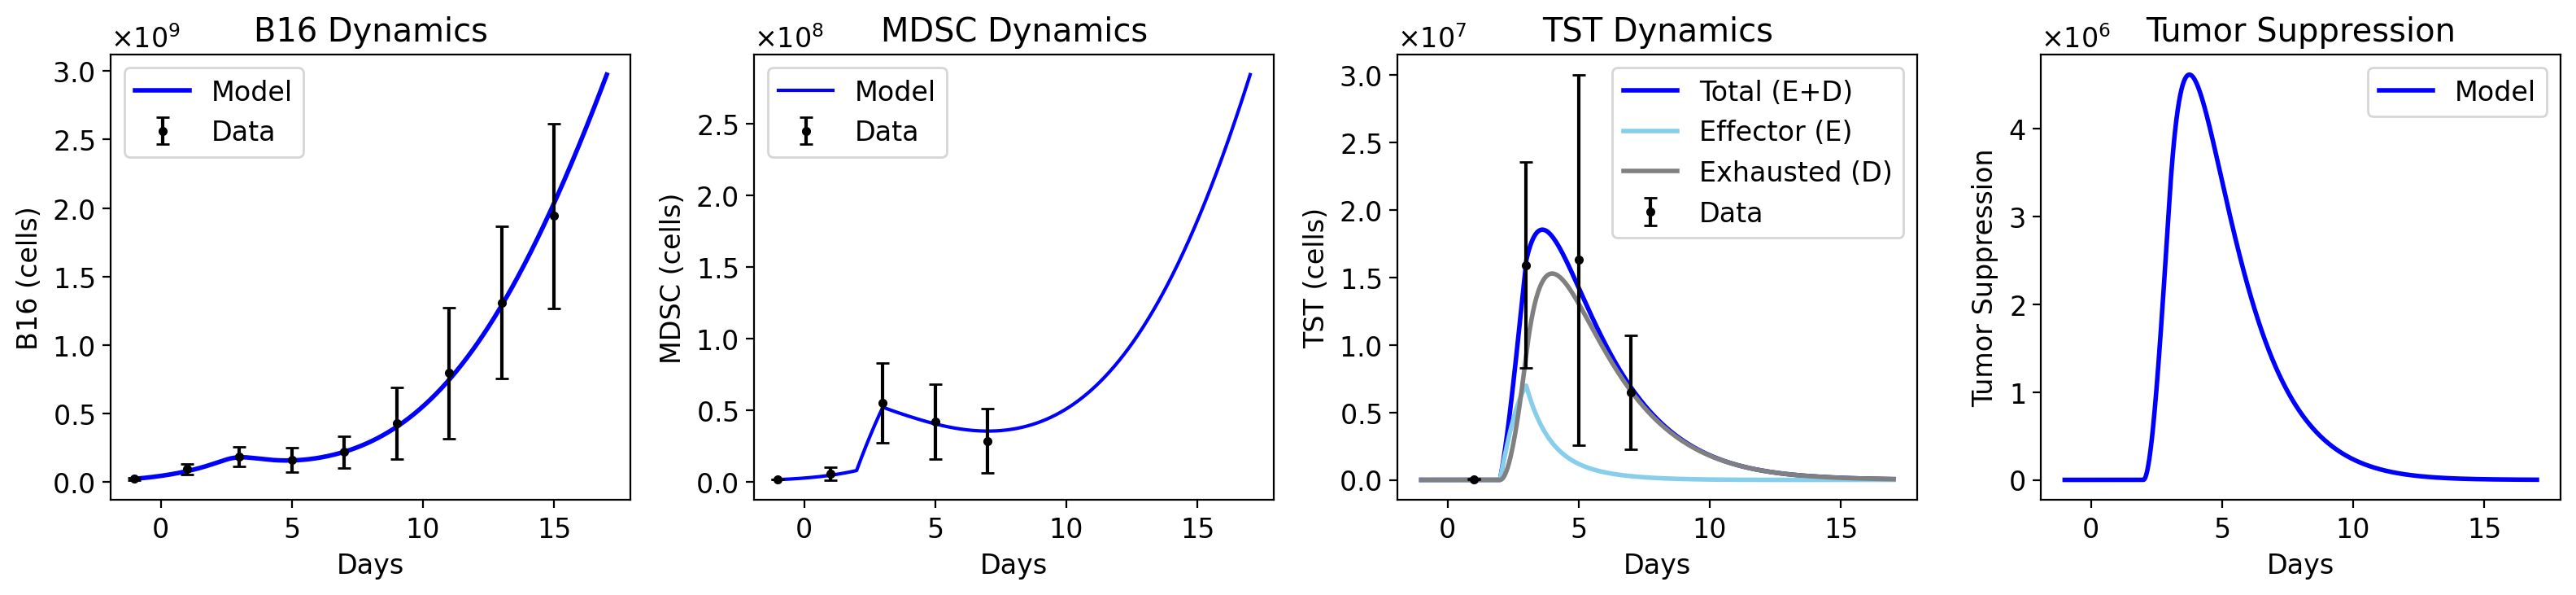

Model2
Figure saved: ../../results/main/02/figS2b.pdf, ../../results/main/02/figS2b.jpeg


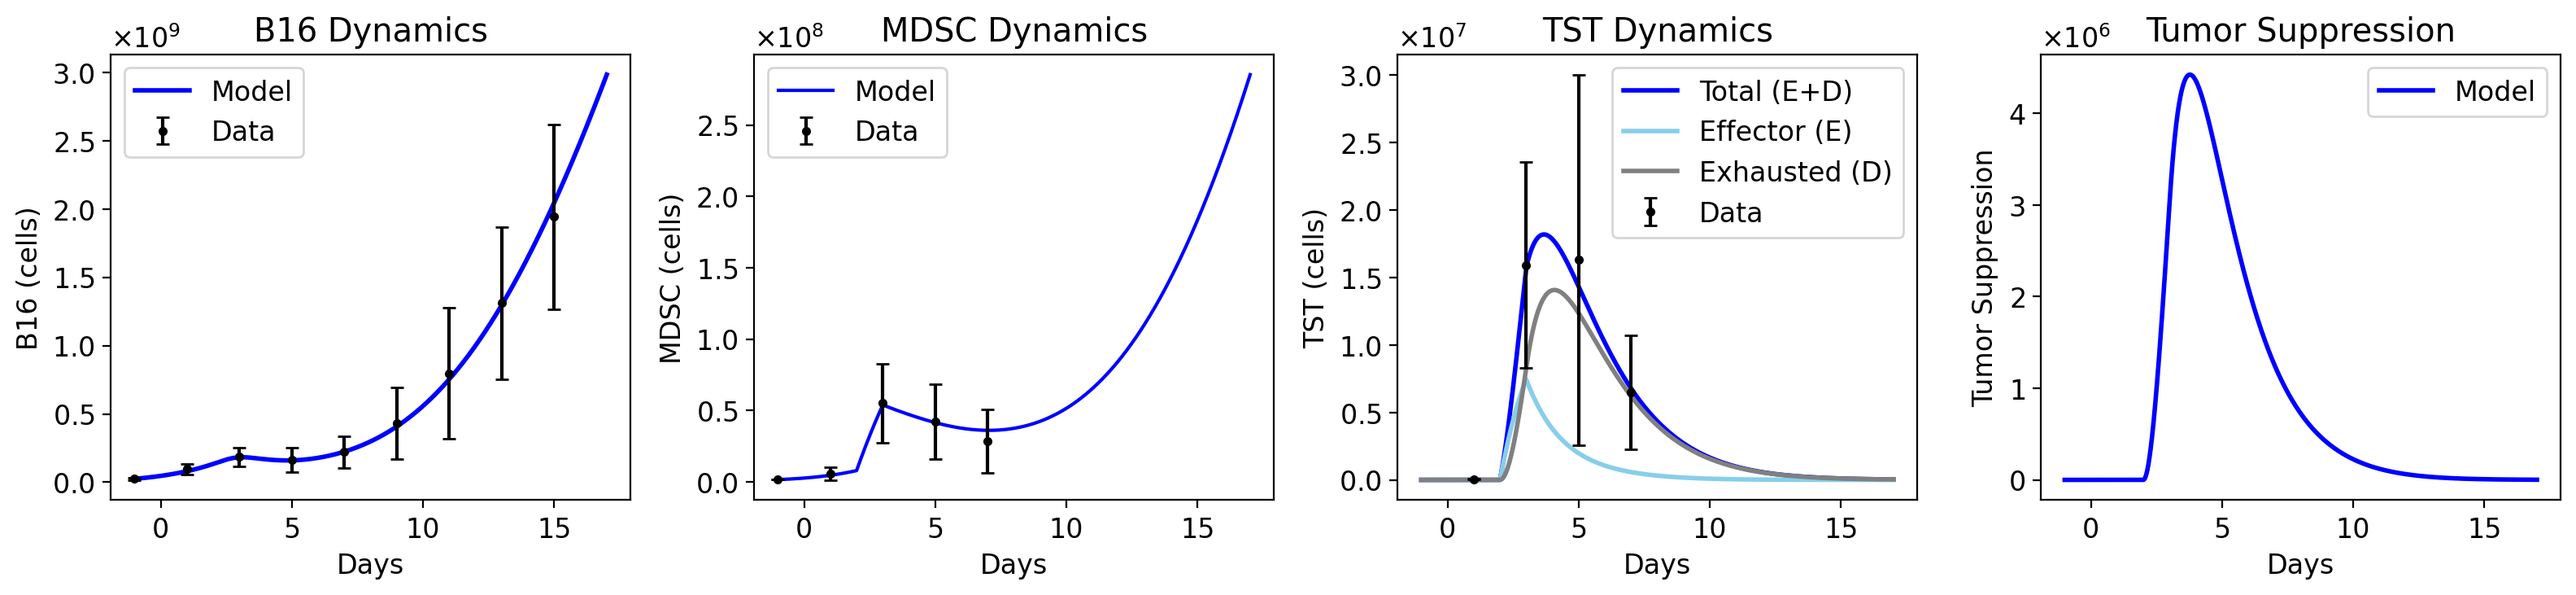

In [81]:
# Time range
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]] # y = [V, E, D, S]
t_eval = np.arange(-1, 17.01, 0.01)

# Fixed CTL injection schedule
dose_list = [1e7] 
dose_days = [0]    
delta_t = 1        

# === Model 1 Simulation ===
sol1 = odeint(model1, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param1),
             hmax=0.01)
V_sol1, E_sol1, D_sol1, S_sol1, M_sol1 = sol1.T
T_sol1 = E_sol1+D_sol1


# === Model 2 Simulation ===
sol2 = odeint(model2, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param2),
             hmax=0.01)
V_sol2, E_sol2, D_sol2, S_sol2, M_sol2 = sol2.T
T_sol2 = E_sol2+D_sol2

print("Model1")
vis_act_fit(sol1, dir_path, "figS2a")
print("Model2")
vis_act_fit(sol2, dir_path, "figS2b")

In [82]:
(v_data[0]/10)/1e6

2.4982352941176473

Model1


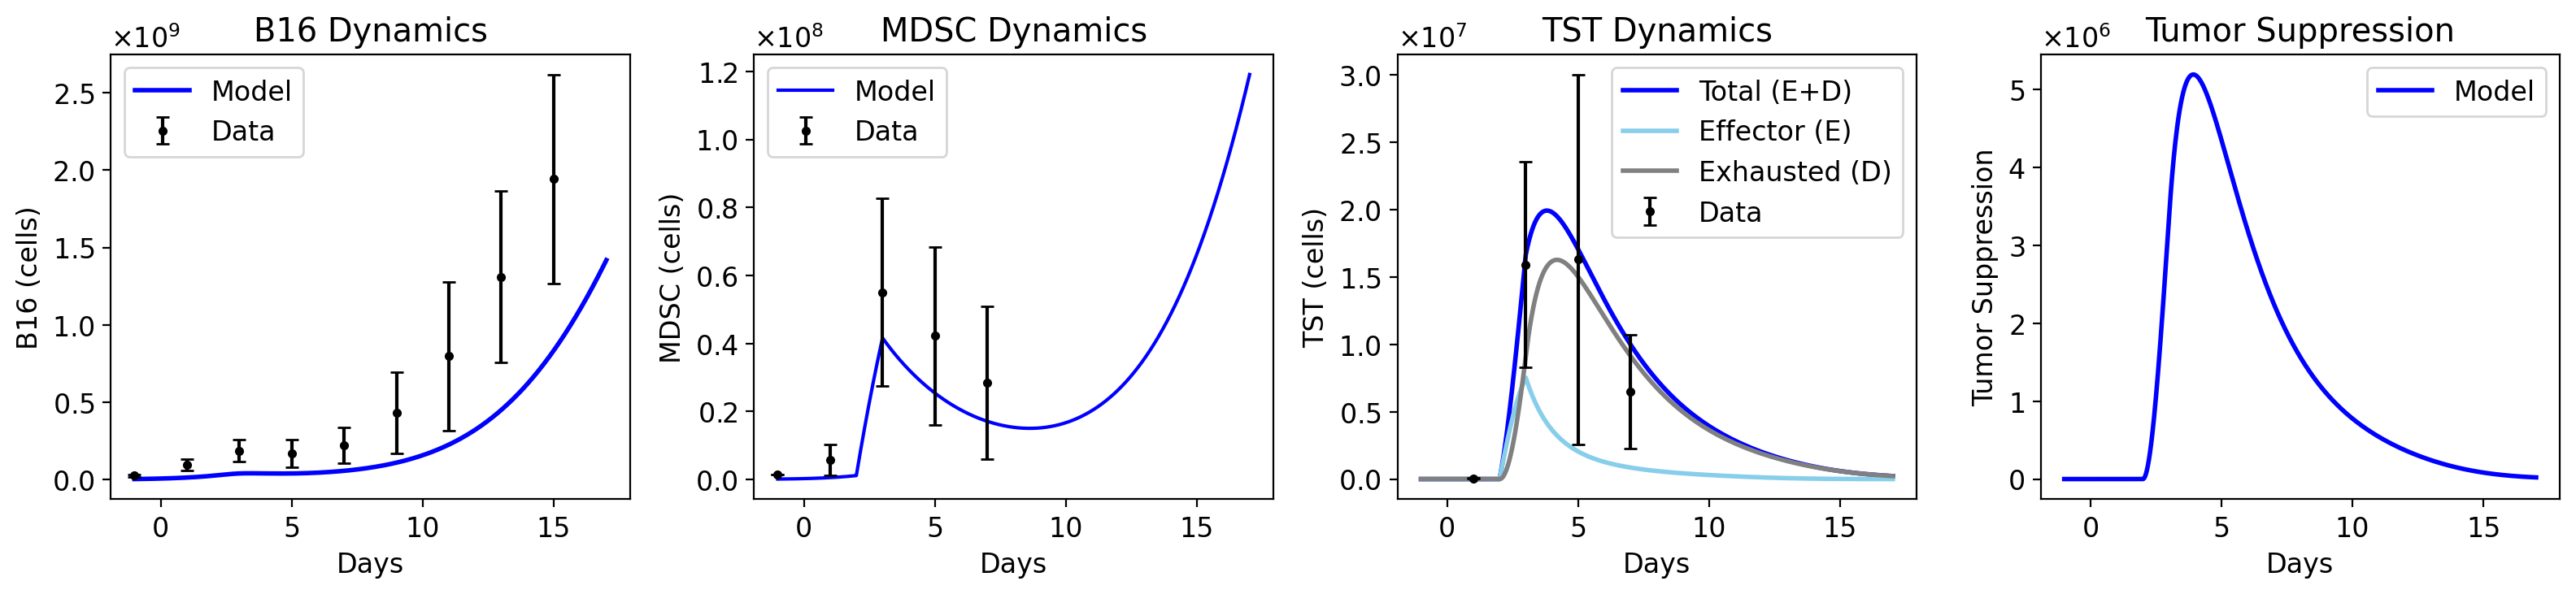

Model2


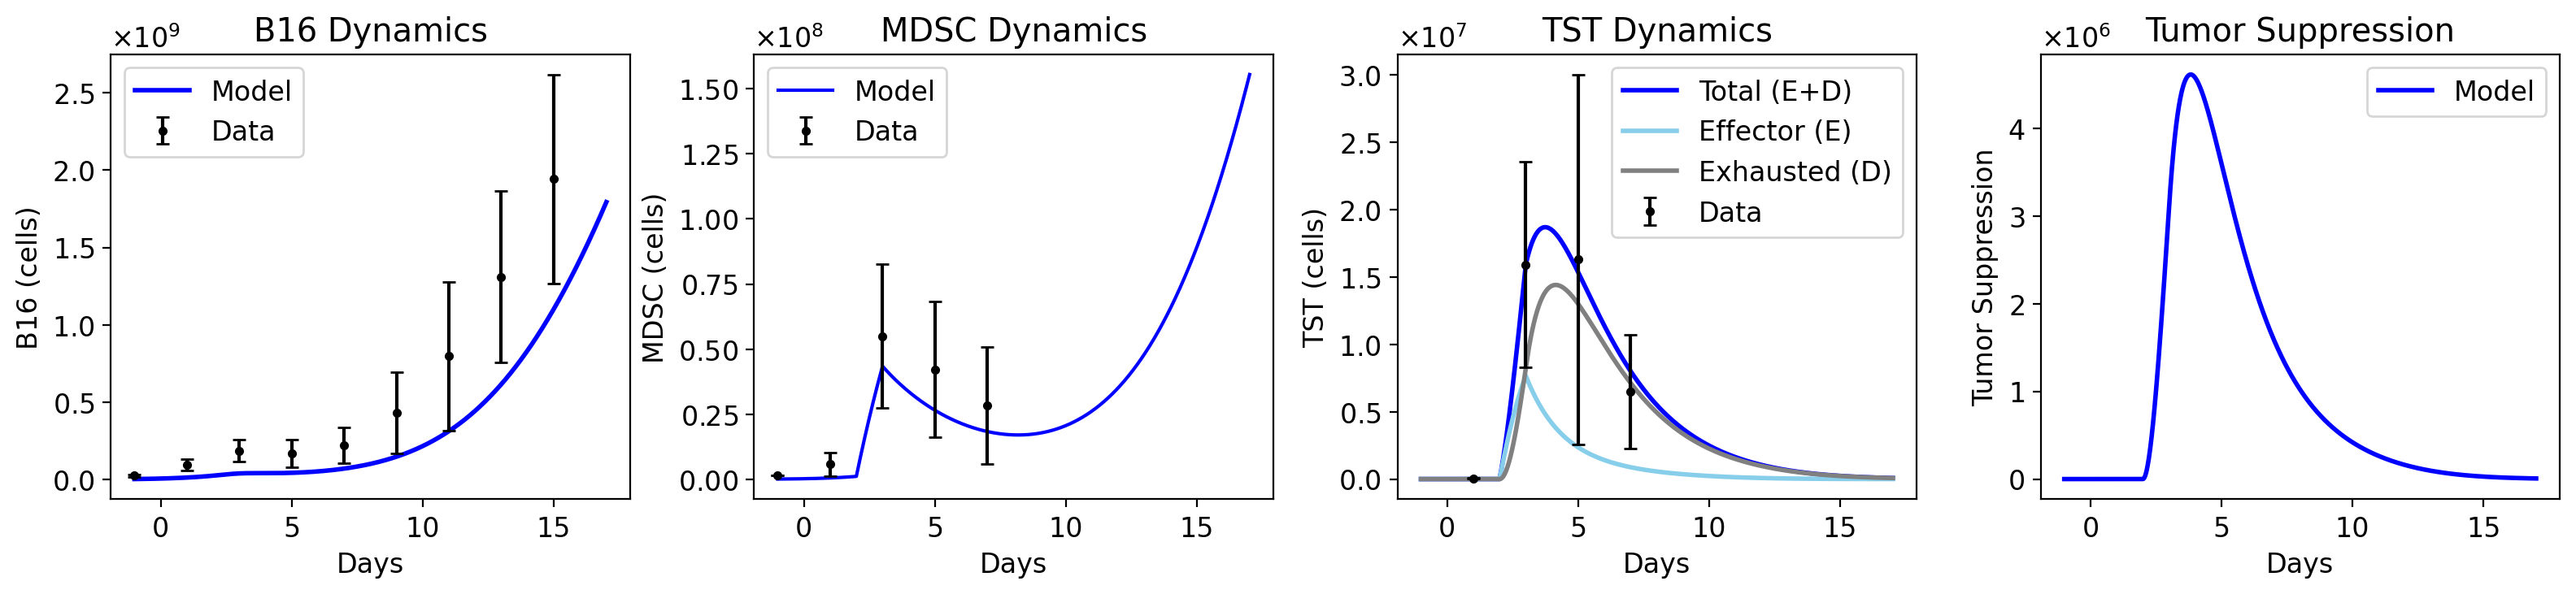

In [83]:
# Time range
y0 = [v_data[0]/10, 0, 0, 0, mdsc_data[0]/10] # y = [V, E, D, S]
t_eval = np.arange(-1, 17.01, 0.01)

# Fixed CTL injection schedule
dose_list = [1e7] 
dose_days = [0]    
delta_t = 1        

# === Model 1 Simulation ===
sol1 = odeint(model1, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param1),
             hmax=0.01)
V_sol1, E_sol1, D_sol1, S_sol1, M_sol1 = sol1.T
T_sol1 = E_sol1+D_sol1


# === Model 2 Simulation ===
sol2 = odeint(model2, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param2),
             hmax=0.01)
V_sol2, E_sol2, D_sol2, S_sol2, M_sol2 = sol2.T
T_sol2 = E_sol2+D_sol2

print("Model1")
vis_act_fit(sol1, dir_path, None)
print("Model2")
vis_act_fit(sol2, dir_path, None)

# Figure S2. Several dose Simulation

In [84]:
# Growth
def growth_cal(V_t, t_data):
    growth_rate = np.log(V_t[1:] / V_t[:-1]) / (t_data[1:] - t_data[:-1])
    return growth_rate, (t_data[1:]+t_data[:-1])/2

def growth_ratio_data(data, treatment):
    B16_Cond = data[(data['Condition'] == treatment)].copy()
    B16_Cond['Experiment_id'] = B16_Cond['Experiment'] + "_" + B16_Cond['id'].astype(str)
    B16_grouped = B16_Cond.groupby('Experiment_id')
    B16_Cond['day_average'] = B16_grouped['day'].shift(1).add(B16_Cond['day']).div(2)
    B16_Cond['change_ratio'] = np.log(B16_Cond['tumor_volume'] / B16_grouped['tumor_volume'].shift(1)) / (B16_Cond['day'] - B16_grouped['day'].shift(1))
    B16_Cond = B16_Cond.dropna()
    B16_ratio = B16_Cond.groupby('day_average')['change_ratio'].agg(['mean', 'std']).reset_index()
    
    return B16_ratio

In [85]:
dose_labels       = ['TST×1', 'TST×2', 'TST×3', 'TST×4']
dose_days_list    = [[0], [0,7], [0,7,14], [0,7,14,21]]
dose_amounts_list = [
    [1e7],
    [1e7, 1e7],
    [1e7, 1e7, 1e7],
    [1e7, 1e7, 1e7, 1e7]
]

# Precompute time vectors for each panel
time_vectors = [
    np.arange(-1, 15*i + 17.01, 0.01)
    for i in range(len(dose_labels))
]

In [86]:
B16F10_sD = pd.read_csv("../../data/tumor/B16F10_sD.csv")

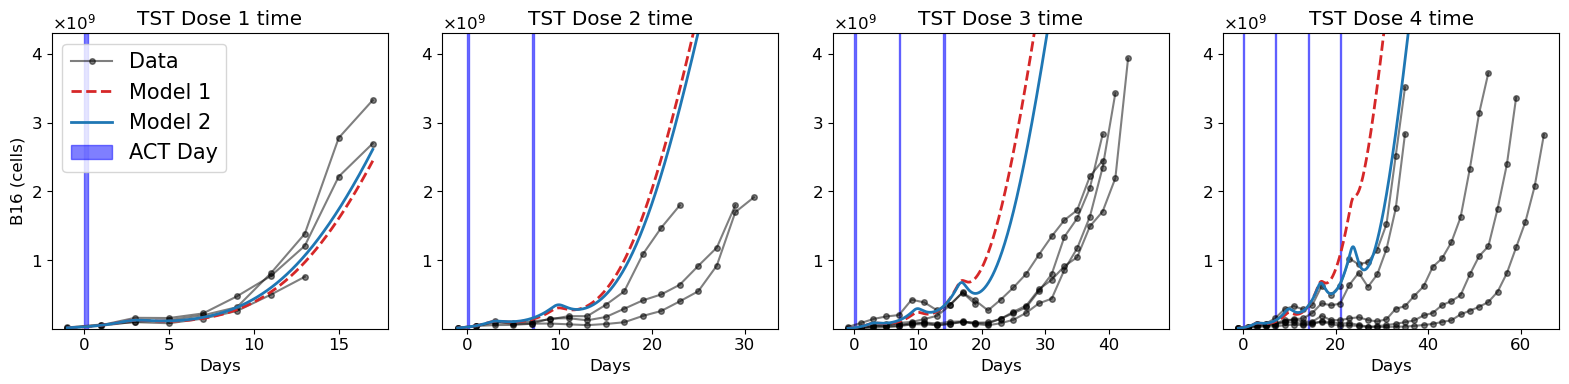

In [87]:
fig_vol, axes_vol = plt.subplots(1, 4, figsize=(16, 4))
for idx, label in enumerate(dose_labels):
    ax = axes_vol[idx]
    t_sim = time_vectors[idx]

    # Extract data and set initial conditions
    df_cond = B16F10_sD[B16F10_sD['Condition'] == label]
    df_avg  = tumor_volume(B16F10_sD, label)
    V_init  = df_avg['mean'].iloc[0] * 1e6
    y0      = [V_init, 0, 0, 0, mdsc_data[0]*V_init/v_data[0]]
    #y0 = [v_data[0], 0, 0, 0, mdsc_data[0]]
    
    # Simulate both models
    infusion_duration = 1
    sol1 = odeint(model1, y0, t_sim,
                  args=(dose_amounts_list[idx], dose_days_list[idx],
                        infusion_duration, param1),
                  hmax=0.001)
    sol2 = odeint(model2, y0, t_sim,
                  args=(dose_amounts_list[idx], dose_days_list[idx],
                        infusion_duration, param2),
                  hmax=0.001)

    # Plot each mouse’s tumor‐volume trajectory
    for mouse_id in df_cond['id'].unique():
        df_mouse = df_cond[df_cond['id'] == mouse_id]
        ax.plot(df_mouse['day'],
                df_mouse['tumor_volume'] * 1e6,
                marker='o', markersize=4, alpha=0.5, color='black', 
                label='Data' if mouse_id==1 else None)

    # Overlay simulations
    ax.plot(t_sim, sol1[:, 0], '--',  color='tab:red',   linewidth=2, label='Model 1')
    ax.plot(t_sim, sol2[:, 0], '-', color='tab:blue', linewidth=2, label='Model 2')

    # Shade dosing periods
    for day in dose_days_list[idx]:
        ax.axvspan(day, day + 0.2, color='blue', alpha=0.5, label='ACT Day')

    ax.set_title(f'TST Dose {idx+1} time')
    if idx == 0:
        ax.set_ylabel('B16 (cells)')
        ax.legend(loc='upper left', fontsize=15)
    ax.set_xlabel('Days')
    ax.set_ylim(1e5, 4.3e9)
    #ax.set_yscale('log')
    
plt.tight_layout()

for ax in axes_vol:
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

fig_vol.savefig(os.path.join(dir_path, "fig2a.pdf"), dpi=300)
fig_vol.savefig(os.path.join(dir_path, "fig2a.jpeg"), dpi=300)

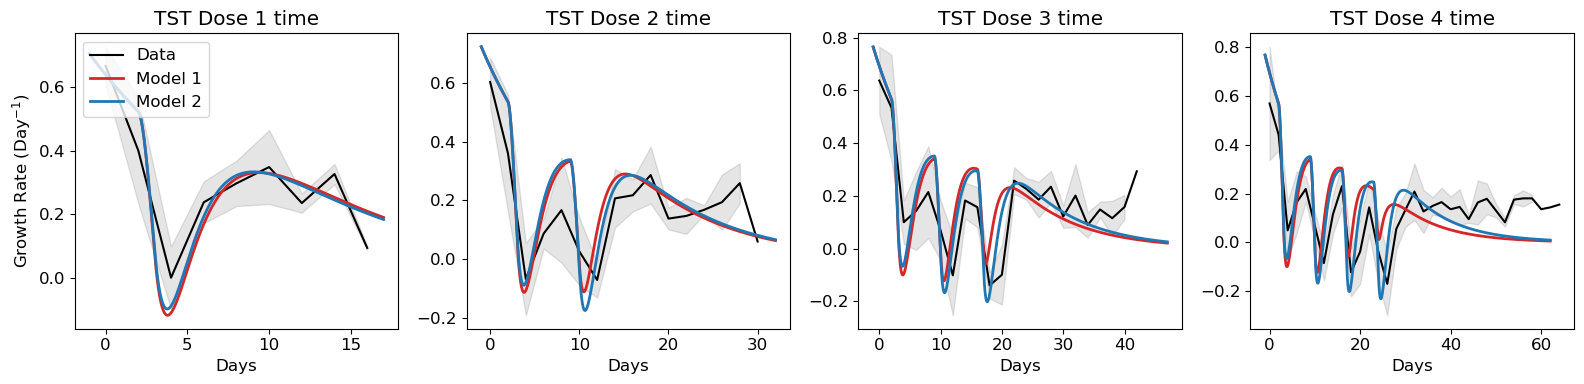

In [88]:
fig_gr, axes_gr = plt.subplots(1, 4, figsize=(16, 4))

for idx, label in enumerate(dose_labels):
    ax = axes_gr[idx]
    t_sim = time_vectors[idx]

    # Experimental growth‐rate summary
    gr_df = growth_ratio_data(B16F10_sD, label)

    # Initial conditions
    df_avg = tumor_volume(B16F10_sD, label)
    V_init = df_avg['mean'].iloc[0] * 1e6
    y0     = [V_init, 0, 0, 0, mdsc_data[0] * V_init / v_data[0]]
    #y0 = [v_data[0], 0, 0, 0, mdsc_data[0]]
    
    # Simulate both models
    sol1 = odeint(model1, y0, t_sim,
                  args=(dose_amounts_list[idx], dose_days_list[idx],
                        infusion_duration, param1),
                  hmax=0.001)
    
    sol2 = odeint(model2, y0, t_sim,
                  args=(dose_amounts_list[idx], dose_days_list[idx],
                        infusion_duration, param2),
                  hmax=0.001)

    # Compute simulated growth rates
    gr1_vals, days1 = growth_cal(sol1[:, 0], t_sim)
    gr2_vals, days2 = growth_cal(sol2[:, 0], t_sim)

    # Plot mean±SD ribbon and mean line
    ax.fill_between(
        gr_df['day_average'],
        gr_df['mean'] + gr_df['std'],
        gr_df['mean'] - gr_df['std'],
        color='black', alpha=0.1
    )
    ax.plot(gr_df['day_average'], gr_df['mean'],
            '-', color='black', label='Data')

    # Overlay simulated curves
    ax.plot(days1, gr1_vals, '-',  color='tab:red',   linewidth=2, label='Model 1')
    ax.plot(days2, gr2_vals, '-', color='tab:blue', linewidth=2, label='Model 2')

    # Shade dosing periods
    #for day in dose_days_list[idx]:
    #    ax.axvspan(day, day + 0.2, color='tab:blue', alpha=0.5, label='ACT Day')

    ax.set_title(f'TST Dose {idx+1} time')
    if idx == 0:
        ax.set_ylabel('Growth Rate (Day$^{-1}$)')
        ax.legend(loc='upper left', fontsize=12)
    ax.set_xlabel('Days')

plt.tight_layout()

fig_gr.savefig(os.path.join(dir_path, "fig2b.pdf"), dpi=300)
fig_gr.savefig(os.path.join(dir_path, "fig2b.jpeg"), dpi=300)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2300000000000D+02   r2 =  0.5680591454325D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2300000000000D+02   r2 =  0.5680591454325D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2300000000000D+02   r2 =  0.5680591454325D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2300000000000D+02   r2 =  0.5680591454325D-15
 lsoda--  warning..internal t (=r1) 

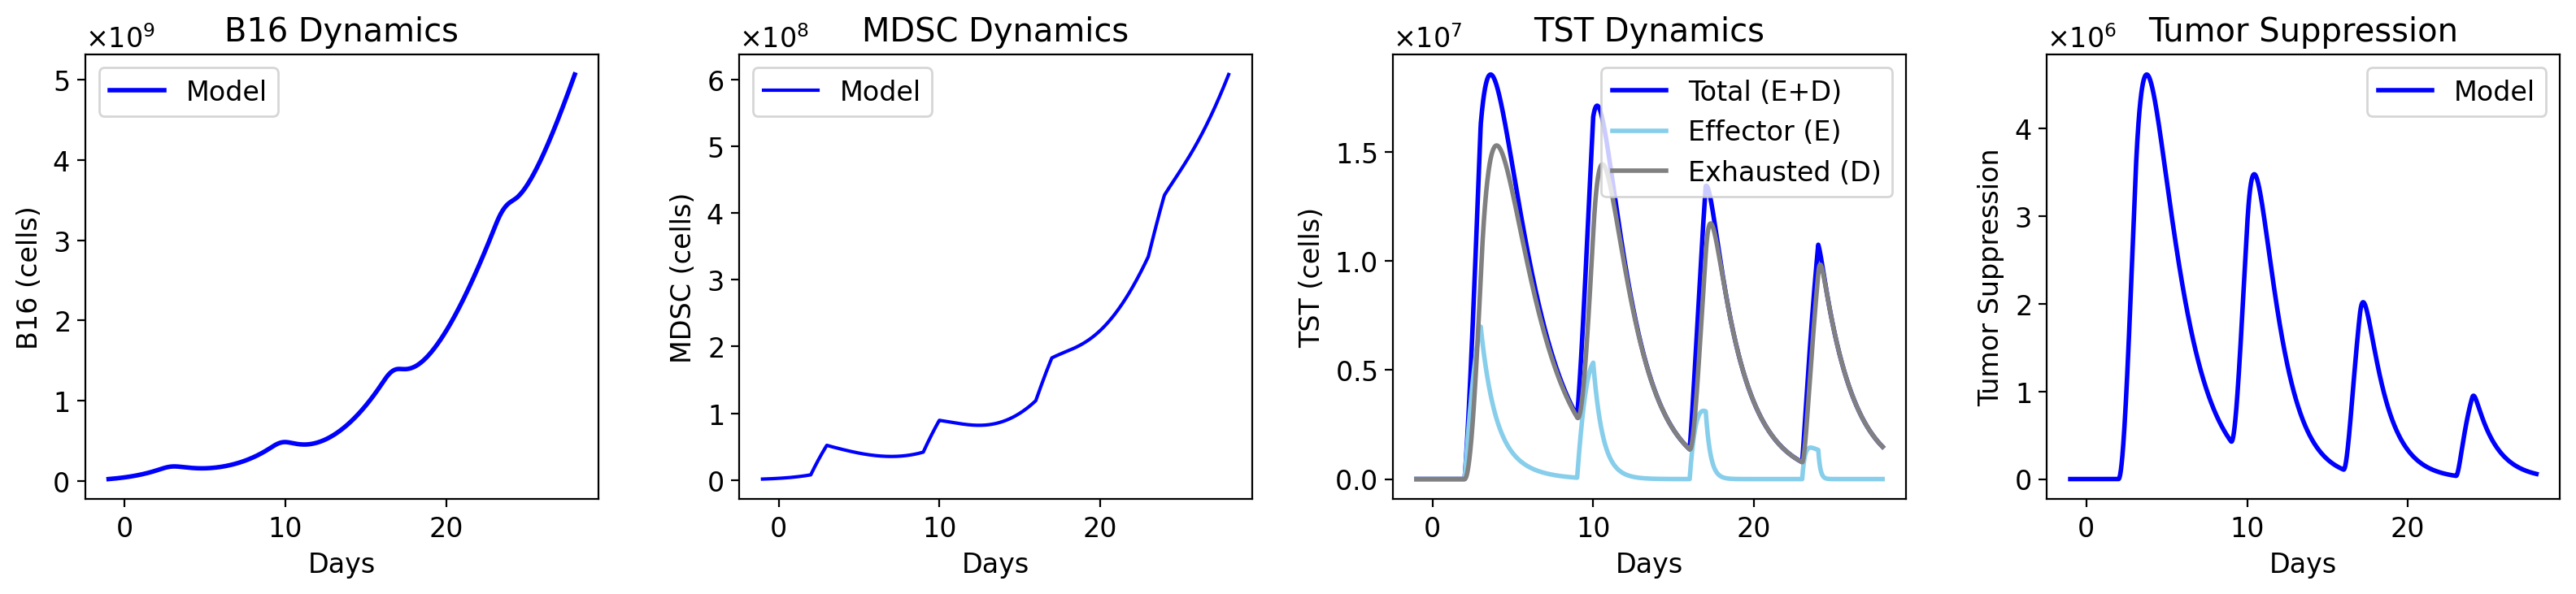

Model2
Figure saved: ../../results/main/02/figS2d.pdf, ../../results/main/02/figS2d.jpeg


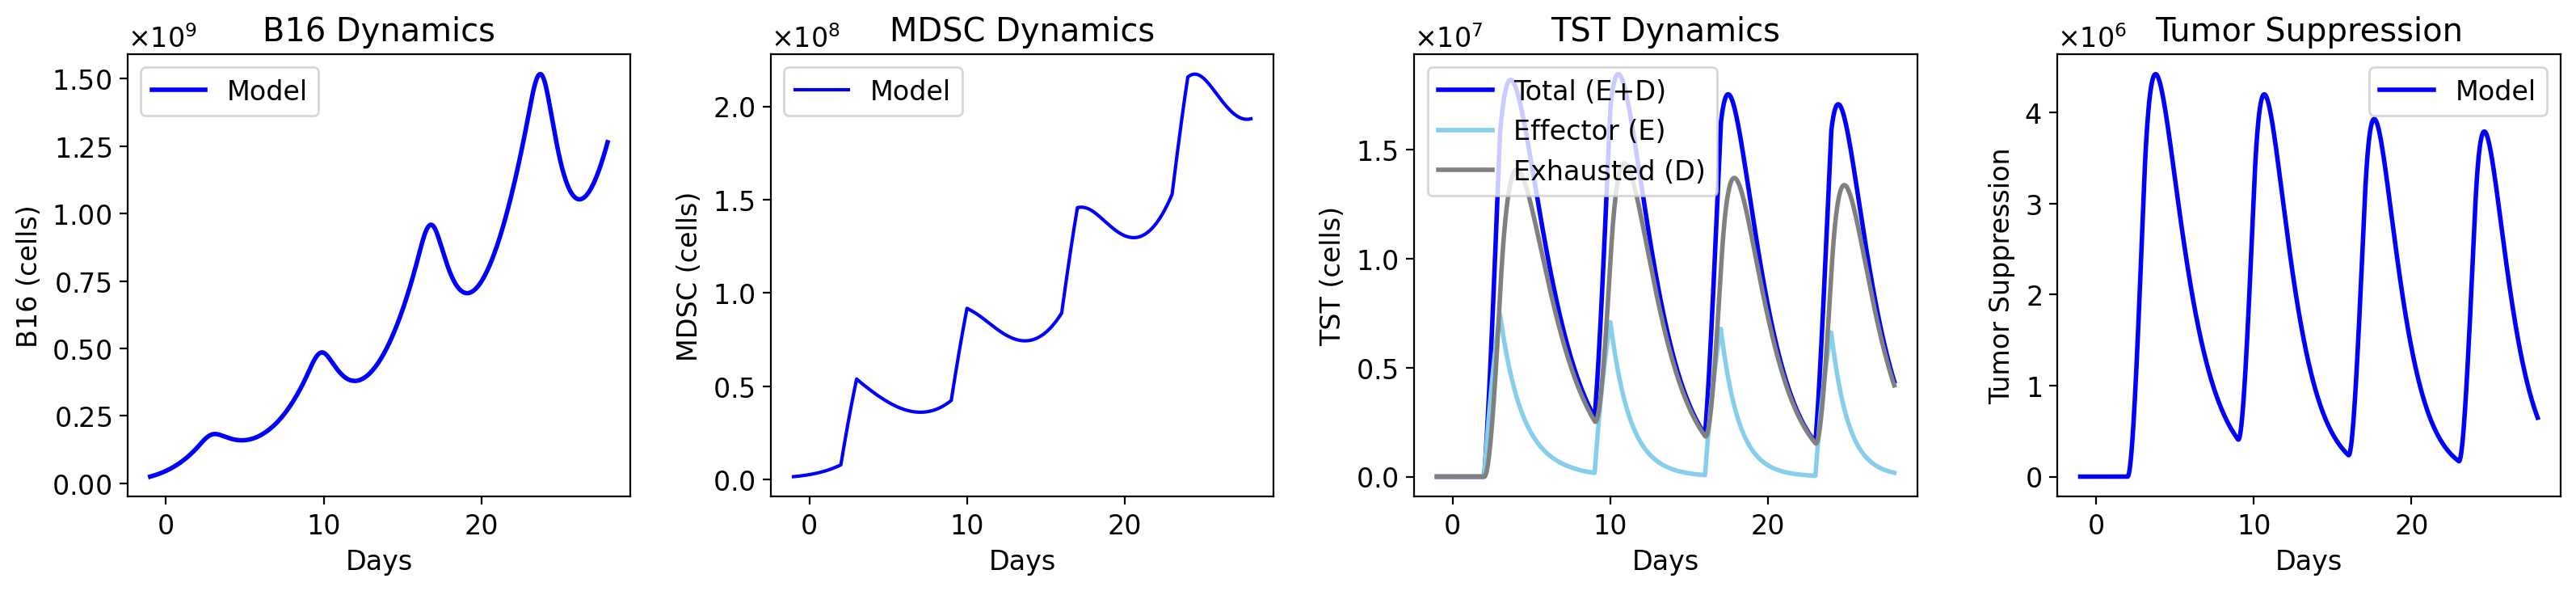

In [89]:
# Time range
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]] # y = [V, E, D, S]
t_eval = np.arange(-1, 28.01, 0.01)

# Fixed CTL injection schedule
dose_list = [1e7, 1e7, 1e7, 1e7] 
dose_days = [0, 7, 14, 21]    
delta_t = 1        

# === Model 1 Simulation ===
sol1 = odeint(model1, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param1),
             hmax=0.001)
V_sol1, E_sol1, D_sol1, S_sol1, M_sol1 = sol1.T
T_sol1 = E_sol1+D_sol1

# === Model 2 Simulation ===
sol2 = odeint(model2, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param2),
             hmax=0.001)
V_sol2, E_sol2, D_sol2, S_sol2, M_sol2 = sol2.T
T_sol2 = E_sol2+D_sol2

print("Model1")
vis_act(sol1, dir_path, "figS2c")
print("Model2")
vis_act(sol2, dir_path, "figS2d")

# CPTIO validation

In [90]:
# Example: print parameter summary
for name, res in results.items():
    print(f"\n{name} Parameters:")
    for pname, pval in res['param_dict'].items():
        print(f"  {pname}: {pval:.4e}")


Model1 Parameters:
  k_s: 1.2617e-07
  e_p: 1.9226e+00
  d_e: 1.9902e+00
  d_d: 5.0527e-01
  d_s: 7.3682e-01
  d_m: 1.7861e-08
  m_f: 4.5746e+00

Model2 Parameters:
  k_s: 1.3104e-07
  e_p: 1.8338e+00
  d_e: 1.9608e+00
  d_d: 6.3755e-01
  d_s: 9.9399e-01
  d_m: 8.9600e-01
  m_f: 4.7826e+00
  k_m: 3.1554e+07


In [91]:
param1_cptio = param1.copy()
param1_cptio[5] *= 0.63
param1_cptio

array([1.26171732e-07, 1.92257886e+00, 1.99019256e+00, 5.05271546e-01,
       7.36820206e-01, 1.12527060e-08, 4.57458311e+00])

In [92]:
param2_cptio = param2.copy()
param2_cptio[5] *= 0.63
param2_cptio

array([1.31043887e-07, 1.83382032e+00, 1.96080371e+00, 6.37550681e-01,
       9.93985152e-01, 5.64482337e-01, 4.78255625e+00, 3.15538345e+07])

In [93]:
B16F10 = pd.read_csv("../../data/tumor/B16F10.csv")
B16F10['Condition'].unique()

array(['Untreated', 'TST', 'TST+RatIgG', 'TST+anti-IFNg', 'CPTIO_Day1-5',
       'TST+CPTIO_Day1-5', 'anti-PD1', 'CPTIO', 'TST+anti-PD1',
       'TST+CPTIO', 'TST+anti-PD1+CPTIO'], dtype=object)

In [94]:
# Time range
y0 = [v_data[0]*2/3, 0, 0, 0, mdsc_data[0]*2/3] # y = [V, E, D, S]

t_eval = np.arange(-1, 17.01, 0.01)

# Fixed CTL injection schedule
dose_list = [1e7] 
dose_days = [0]    
delta_t = 1        

# === Model 1 Simulation ===
sol1 = odeint(model1, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param1),
             hmax=0.01)
V_sol1, E_sol1, D_sol1, S_sol1, M_sol1 = sol1.T
T_sol1 = E_sol1+D_sol1


# === Model 1 CPTIO Simulation ===
sol2 = odeint(model1, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param1_cptio),
             hmax=0.01)
V_sol2, E_sol2, D_sol2, S_sol2, M_sol2 = sol2.T
T_sol2 = E_sol2+D_sol2

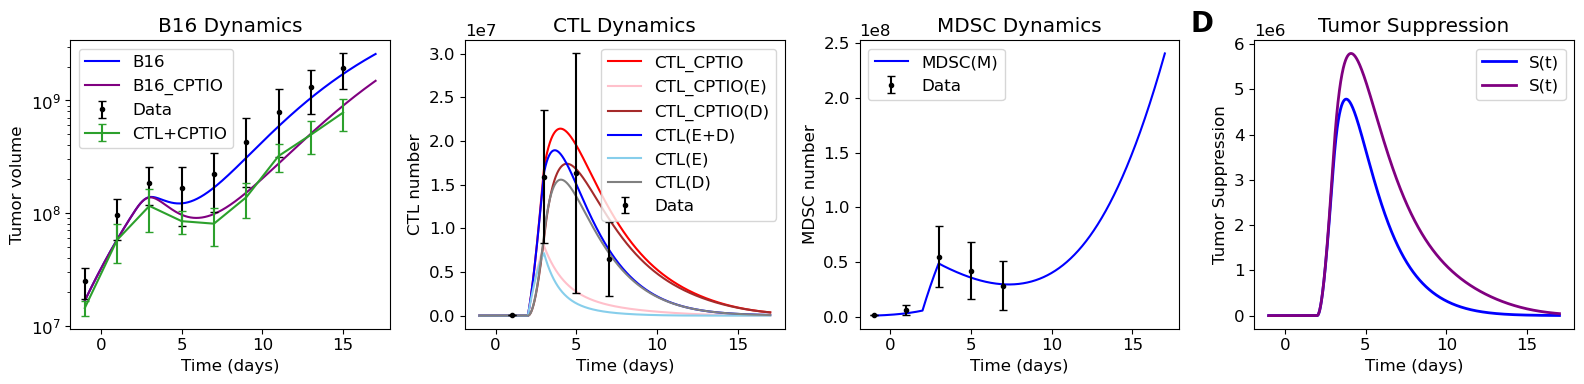

In [95]:
# プロット
plt.figure(figsize=(16, 4))

# 腫瘍
plt.subplot(1, 4, 1)
plt.plot(t_eval, V_sol1, label='B16', color='blue')
plt.plot(t_eval, V_sol2, label='B16_CPTIO', color='purple')
plt.errorbar(v_days, v_data, yerr=v_std, fmt='o', color='black', capsize=3, markersize=3, label='Data')
plt.errorbar(tumor_volume(B16F10, 'TST+CPTIO')['day'],tumor_volume(B16F10, 'TST+CPTIO')['mean']*1e6,
        yerr=tumor_volume(B16F10, 'TST+CPTIO')['std']*1e6,label='CTL+CPTIO', capsize=3, color='tab:green')
plt.yscale('log')
plt.xlabel("Time (days)")
plt.ylabel("Tumor volume")
plt.title("B16 Dynamics")
plt.legend()

# CTL
plt.subplot(1, 4, 2)
plt.plot(t_eval, T_sol2, label='CTL_CPTIO', color='red')
plt.plot(t_eval, E_sol2, label='CTL_CPTIO(E)', color='pink')
plt.plot(t_eval, D_sol2, label='CTL_CPTIO(D)', color='brown')


plt.plot(t_eval, T_sol1, label='CTL(E+D)', color='blue')
plt.plot(t_eval, E_sol1, label='CTL(E)', color='skyblue')
plt.plot(t_eval, D_sol1, label='CTL(D)', color='gray')
plt.errorbar(ctl_days, ctl_data, yerr=ctl_std, fmt='o', color='black', capsize=3, markersize=3, label='Data')
plt.xlabel("Time (days)")
plt.ylabel("CTL number")
plt.title("CTL Dynamics")
plt.legend()

# MDSC
plt.subplot(1, 4, 3)
plt.plot(t_eval, M_sol1, label='MDSC(M)', color='blue')
plt.errorbar(mdsc_days, mdsc_data, yerr=mdsc_std, fmt='o', color='black', capsize=3, markersize=3, label='Data')
plt.xlabel("Time (days)")
plt.ylabel("MDSC number")
plt.title("MDSC Dynamics")
plt.legend()

# --- Panel C: Suppression Effect ---
plt.subplot(1, 4, 4)
plt.title('D', loc='left', fontsize=20, fontweight='bold', position=(-0.2,1))
plt.plot(t_eval, S_sol1, label='S(t)', color='blue', linewidth=2)
plt.plot(t_eval, S_sol2, label='S(t)', color='purple', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Tumor Suppression')
plt.title('Tumor Suppression')
plt.legend()

plt.tight_layout()
plt.show()

In [96]:
# === Model 1 Simulation ===
sol1 = odeint(model2, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param2),
             hmax=0.01)
V_sol1, E_sol1, D_sol1, S_sol1, M_sol1 = sol1.T
T_sol1 = E_sol1+D_sol1


# === Model 2 Simulation ===
sol2 = odeint(model2, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param2_cptio),
             hmax=0.01)
V_sol2, E_sol2, D_sol2, S_sol2, M_sol2 = sol2.T
T_sol2 = E_sol2+D_sol2

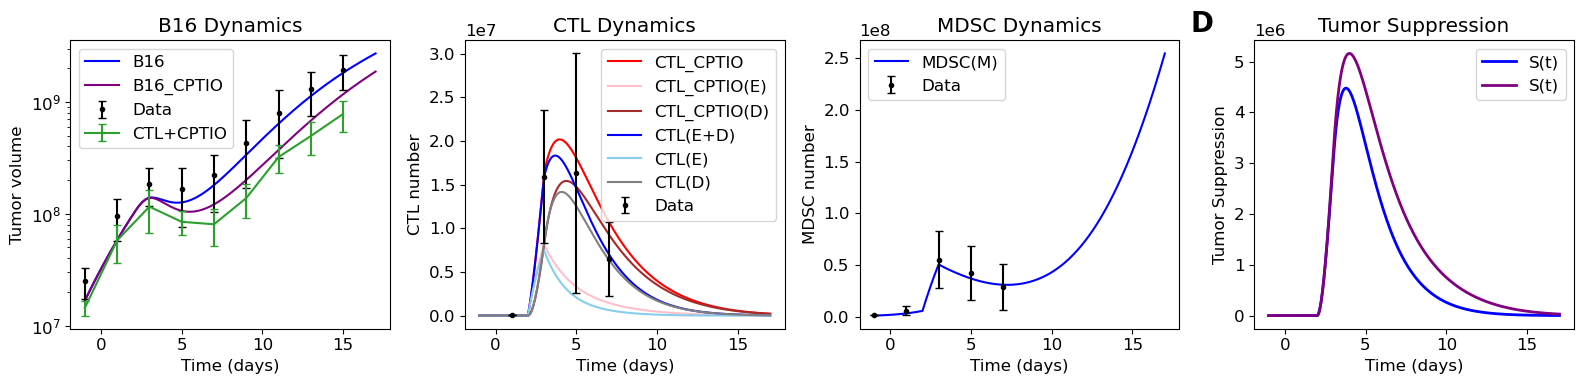

In [97]:
# プロット
plt.figure(figsize=(16, 4))

# 腫瘍
plt.subplot(1, 4, 1)
plt.plot(t_eval, V_sol1, label='B16', color='blue')
plt.plot(t_eval, V_sol2, label='B16_CPTIO', color='purple')
plt.errorbar(v_days, v_data, yerr=v_std, fmt='o', color='black', capsize=3, markersize=3, label='Data')
plt.errorbar(tumor_volume(B16F10, 'TST+CPTIO')['day'],tumor_volume(B16F10, 'TST+CPTIO')['mean']*1e6,
        yerr=tumor_volume(B16F10, 'TST+CPTIO')['std']*1e6,label='CTL+CPTIO', capsize=3, color='tab:green')
plt.yscale('log')
plt.xlabel("Time (days)")
plt.ylabel("Tumor volume")
plt.title("B16 Dynamics")
plt.legend()

# CTL
plt.subplot(1, 4, 2)
plt.plot(t_eval, T_sol2, label='CTL_CPTIO', color='red')
plt.plot(t_eval, E_sol2, label='CTL_CPTIO(E)', color='pink')
plt.plot(t_eval, D_sol2, label='CTL_CPTIO(D)', color='brown')


plt.plot(t_eval, T_sol1, label='CTL(E+D)', color='blue')
plt.plot(t_eval, E_sol1, label='CTL(E)', color='skyblue')
plt.plot(t_eval, D_sol1, label='CTL(D)', color='gray')
plt.errorbar(ctl_days, ctl_data, yerr=ctl_std, fmt='o', color='black', capsize=3, markersize=3, label='Data')
plt.xlabel("Time (days)")
plt.ylabel("CTL number")
plt.title("CTL Dynamics")
plt.legend()

# MDSC
plt.subplot(1, 4, 3)
plt.plot(t_eval, M_sol1, label='MDSC(M)', color='blue')
plt.errorbar(mdsc_days, mdsc_data, yerr=mdsc_std, fmt='o', color='black', capsize=3, markersize=3, label='Data')
plt.xlabel("Time (days)")
plt.ylabel("MDSC number")
plt.title("MDSC Dynamics")
plt.legend()

# --- Panel C: Suppression Effect ---
plt.subplot(1, 4, 4)
plt.title('D', loc='left', fontsize=20, fontweight='bold', position=(-0.2,1))
plt.plot(t_eval, S_sol1, label='S(t)', color='blue', linewidth=2)
plt.plot(t_eval, S_sol2, label='S(t)', color='purple', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Tumor Suppression')
plt.title('Tumor Suppression')
plt.legend()

plt.tight_layout()
plt.show()